In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings("ignore") # umap deprecation warnings related to numba do not concern us.

In [2]:
from pathlib import Path as path
import functools as fn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scboolseq.utils import parse_data_directory, parse_pickles
from scboolseq import scBoolSeq

from markers import (
    positive_markers, # function to generate a configuration dictionnary from a set of marker genes
    states_and_markers, # Dictionnary containing phenotypes and their marker genes
    marker_genes, # pandas.Series containing simply the name of markers
)

In [3]:
%ls *csv

dorothea_mouse_tfs.csv                pseudotime_inferred_observations.csv
GSE122466_Retina_vargenes_batch1.csv  scboolseq_inferred_observations.csv


In [4]:
data = pd.read_csv("GSE122466_Retina_vargenes_batch1.csv", index_col=0)
print(data.shape)
data.head()

(2673, 1650)


,Tubb3,Malat1,Stmn2,Fgf15,Gap43,Xist,Sncg,Hmgb2,Top2a,Meg3,...,Kif14,Etfb,Prdm13,Cd320,Odf2,Rpl24,Fam98b,Fbxo36,Pou4f2,Rbp4
Lane1_AAACCTGAGATGTCGG,0.000000,14.687273,9.280150,10.278990,0.000000,0.000000,8.282469,10.863565,8.282469,8.282469,...,0.0,0.000000,0.0,0.000000,0.000000,11.737682,0.000000,0.0,0.0,0.0
Lane1_AAACCTGCAATCCAAC,0.000000,14.568977,0.000000,10.200911,0.000000,0.000000,0.000000,10.200911,0.000000,0.000000,...,0.0,9.616560,0.0,0.000000,0.000000,10.615642,8.618397,0.0,0.0,0.0
Lane1_AAACCTGGTTCCTCCA,12.822128,16.422850,11.681013,0.000000,12.722607,0.000000,12.615708,0.000000,0.000000,11.237565,...,0.0,6.607977,0.0,0.000000,6.607977,9.402599,6.607977,0.0,0.0,0.0
Lane1_AAACCTGTCCAATGGT,12.601411,16.106194,10.514703,0.000000,8.517658,0.000000,8.517658,10.099994,0.000000,0.000000,...,0.0,0.000000,0.0,8.517658,0.000000,10.099994,0.000000,0.0,0.0,0.0
Lane1_AAACGGGAGGCAATTA,0.000000,14.858160,0.000000,12.375060,7.766719,11.082672,6.773328,11.889742,11.461031,7.766719,...,0.0,6.773328,0.0,0.000000,6.773328,11.284220,8.349471,0.0,0.0,0.0


In [5]:
obs_tags = pd.read_csv("pseudotime_inferred_observations.csv", index_col=0)
obs_tags.observation.value_counts()

observation
RPC      202
AC       107
NB1       79
RGC       68
Cones     65
NB2        7
Name: count, dtype: int64

In [6]:
%%time
scbool = scBoolSeq(
    dor_threshold=0.995, # To retain one of the markers
    confidence=.75 # To maximize binarization
)
scbool.fit(data)

CPU times: user 1min 34s, sys: 1.26 s, total: 1min 36s
Wall time: 17.7 s


scBoolSeqBinarizer(confidence=0.75, dor_threshold=0.995)

In [7]:
scbool.criteria_.Category.value_counts()

Category
Bimodal     853
ZeroInf     723
Unimodal     74
Name: count, dtype: int64

In [8]:
scbool.criteria_.loc[marker_genes, :].Category.value_counts()

Category
ZeroInf    12
Bimodal    10
Name: count, dtype: int64

In [9]:
%time bin_data = scbool.binarize(data)

CPU times: user 1.71 s, sys: 28.1 ms, total: 1.74 s
Wall time: 1.74 s


In [10]:
partial_bin_configs = bin_data[marker_genes]
partial_bin_configs.fillna('').head()

,Penk,Rbp4,Hes1,Elavl4,Pax6,Prox1,Otx2,Onecut1,Crx,Sox2,...,Top2a,Pcdh17,Onecut2,Fos,Sstr2,Pou6f2,Btg2,Isl1,Pou4f2,Prc1
Lane1_AAACCTGAGATGTCGG,,,1.0,0.0,1.0,,,,,1.0,...,1.0,,0.0,0.0,,1.0,0.0,0.0,,0.0
Lane1_AAACCTGCAATCCAAC,,,1.0,0.0,1.0,1.0,,,,,...,0.0,,0.0,1.0,,0.0,1.0,0.0,,0.0
Lane1_AAACCTGGTTCCTCCA,,,0.0,1.0,1.0,,,1.0,,,...,0.0,1.0,0.0,0.0,,1.0,0.0,1.0,,0.0
Lane1_AAACCTGTCCAATGGT,,,0.0,0.0,1.0,,,,,,...,0.0,,0.0,0.0,,0.0,1.0,1.0,,0.0
Lane1_AAACGGGAGGCAATTA,,,1.0,0.0,1.0,,,,,,...,1.0,1.0,0.0,1.0,,0.0,1.0,0.0,,1.0


In [11]:
binarized_groups = {}
for obs, frame in obs_tags.groupby('observation'):
    binarized_groups.update({
        obs: bin_data.loc[frame.index, :]
    })

In [12]:
binarized_groups.keys()

dict_keys(['AC', 'Cones', 'NB1', 'NB2', 'RGC', 'RPC'])

### Aggregate groups

Here we perform the following encoding:

$
\begin{equation}\label{eq:bimodalbin}
    f(x) =
    \begin{cases}
        -1 &       \text{if}\;\; x = False\\
         0 &       \text{if}\;\;  x = \text{?}\\
         1 &       \text{if}\;\; x = True
    \end{cases}
\end{equation}
$

And sum accross all observations with the same tag.

We then use a Symmetric binarisation strategy for the sum dritribution.

In [13]:
from scboolseq.binarization import SymmetricBinarizer

In [14]:
%%time

_sym_thresh = .3
agg_obs_sum = []
for group_name, binarized_group in binarized_groups.items():
    _mapped_meta = binarized_group.replace(0.0, -1.0).fillna(0.0)
    _meta_bin = (
        SymmetricBinarizer(threshold=_sym_thresh*_mapped_meta.shape[0], require_df=True)
            .fit_transform(
                _mapped_meta.sum().to_frame()
            )
    )
    _meta_bin.columns = [group_name]
    agg_obs_sum.append(_meta_bin)
    
meta_sum = pd.concat(agg_obs_sum, axis=1).T

CPU times: user 98.3 ms, sys: 64 μs, total: 98.4 ms
Wall time: 97.6 ms


In [15]:
for pheno, genes in states_and_markers.items():
    if pheno in meta_sum.index:
        print(pheno, "\t:\t", meta_sum.loc[pheno, list(genes)].to_dict())

RPC 	:	 {'Sox2': 1.0, 'Hes1': 1.0, 'Fos': 1.0}
NB1 	:	 {'Btg2': 1.0, 'Penk': 1.0, 'Sstr2': nan, 'Top2a': 1.0, 'Prc1': 1.0}
NB2 	:	 {'Pcdh17': 1.0, 'Neurod4': 1.0, 'Pax6': nan}
RGC 	:	 {'Pou6f2': 1.0, 'Elavl4': 1.0, 'Isl1': 1.0, 'Pou4f2': 1.0}
AC 	:	 {'Prox1': 1.0, 'Onecut2': 1.0}
Cones 	:	 {'Rbp4': nan, 'Otx2': 1.0, 'Thrb': 1.0, 'Crx': 1.0}


In [16]:
meta_sum[marker_genes].T

,AC,Cones,NB1,NB2,RGC,RPC
Penk,NaN,NaN,1.0,NaN,NaN,NaN
Rbp4,NaN,NaN,NaN,NaN,NaN,NaN
Hes1,0.0,0.0,0.0,0.0,0.0,1.0
Elavl4,0.0,0.0,0.0,0.0,1.0,0.0
Pax6,1.0,0.0,1.0,NaN,1.0,1.0
Prox1,1.0,NaN,NaN,NaN,NaN,NaN
Otx2,NaN,1.0,1.0,1.0,NaN,NaN
Onecut1,NaN,NaN,NaN,NaN,1.0,NaN
Crx,NaN,1.0,NaN,NaN,NaN,NaN
Sox2,NaN,NaN,NaN,NaN,NaN,1.0


In [17]:
meta_sum.to_csv("meta_sum_bin_aggregated.csv")

In [18]:
null_var_mask = meta_sum.var(skipna=False) == 0
null_var_genes = meta_sum.columns[null_var_mask]
null_var_genes.shape

(67,)

In [19]:
with open("sum_active_invariant_genes.txt", "w") as _active_genes, open("sum_inactive_invariant_genes.txt", "w") as _inactive_genes:
    _active_genes.write(f"Gene\n")
    _inactive_genes.write(f"Gene\n")
    for _gene, _val in meta_sum[null_var_genes].mode().T.itertuples(index=True):
        if _val:
            _active_genes.write(f"{_gene}\n")
        else:
            _inactive_genes.write(f"{_gene}\n")

In [20]:
print(meta_sum.shape)
meta_sum_var = meta_sum
meta_sum.iloc[:, :10]

(6, 1650)


,Tubb3,Malat1,Stmn2,Fgf15,Gap43,Xist,Sncg,Hmgb2,Top2a,Meg3
AC,1.0,NaN,1.0,0.0,1.0,NaN,0.0,0.0,0.0,1.0
Cones,NaN,1.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN
NB1,1.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0
NB2,1.0,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0
RGC,1.0,NaN,1.0,0.0,1.0,0.0,1.0,NaN,0.0,1.0
RPC,NaN,NaN,NaN,1.0,NaN,NaN,0.0,1.0,1.0,0.0


In [21]:
dorothea_db = pd.read_csv("dorothea_mouse_tfs.csv")
dorothea_db.columns = dorothea_db.columns[:-1].to_list() + ['sign']
dorothea_db.head()

,tf,confidence,target,sign
0,4932411N23Rik,E,Smad4,1
1,4932411N23Rik,E,0610030E20Rik,1
2,4932411N23Rik,E,1700017N19Rik,1
3,4932411N23Rik,E,4931428F04Rik,1
4,4932411N23Rik,E,4932438A13Rik,1


In [22]:
def in_db(frame: pd.DataFrame, db: pd.DataFrame):
    is_tf = frame.columns.isin(db.tf)
    is_target = frame.columns.isin(db.target)
    in_db = pd.Series(
        fn.reduce(np.logical_or, [is_tf, is_target]), 
        index=frame.columns
    )
    return in_db

In [23]:
in_db(meta_sum_var, dorothea_db).mean()

0.8987878787878788

In [24]:
in_db(meta_sum_var[marker_genes], dorothea_db).mean()

1.0

In [25]:
meta_sum_var[null_var_genes].columns[~in_db(meta_sum_var[null_var_genes], dorothea_db)]

Index(['Gm42418', 'BC003331', 'Gm26518', 'Mum1'], dtype='object')

In [26]:
print(meta_sum_var.shape)
meta_sum_var_db = meta_sum_var[meta_sum_var.columns[in_db(meta_sum_var, dorothea_db)]]
print(meta_sum_var_db.shape)
meta_sum_var_db.iloc[:, :10]

(6, 1650)
(6, 1483)


,Tubb3,Stmn2,Fgf15,Gap43,Sncg,Hmgb2,Top2a,Ccnd1,Tubb2b,Ebf1
AC,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
Cones,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0
NB1,1.0,NaN,NaN,NaN,0.0,1.0,1.0,NaN,1.0,0.0
NB2,1.0,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0,0.0
RGC,1.0,1.0,0.0,1.0,1.0,NaN,0.0,0.0,1.0,1.0
RPC,NaN,NaN,1.0,NaN,0.0,1.0,1.0,1.0,1.0,0.0


In [27]:
meta_sum_var_db.T.isna().mean()

AC       0.591369
Cones    0.512475
NB1      0.585974
NB2      0.581254
RGC      0.569117
RPC      0.616318
dtype: float64

In [28]:
meta_sum_var_db.isna().mean().mean()

0.5760845133737919

In [29]:
import networkx as nx
from grn import *

In [30]:
dorothea_db.confidence.unique()

array(['E', 'D', 'B', 'A', 'C'], dtype=object)

In [31]:
# The whole grn is weakly connected if we consider all confidence levels
whole_grn = df_to_graph(dorothea_db.query("confidence != 'E' & confidence != 'D'"))
induced_grn = nx.induced_subgraph(whole_grn, meta_sum_var_db.columns)
len(whole_grn), len(induced_grn)

(5201, 622)

In [32]:
core_tf_nw = extract_largest_scc(whole_grn)
len(core_tf_nw)

157

In [33]:
prior_grn = (
    nx.induced_subgraph(
        whole_grn, 
        set(core_tf_nw).union(
            meta_sum_var_db.columns
        )
    )
)
len(prior_grn)

749

In [34]:
nx.is_weakly_connected(prior_grn)

False

In [35]:
pkn_biggest_wcc = nx.subgraph(prior_grn, max(nx.weakly_connected_components(prior_grn), key=len))
len(pkn_biggest_wcc)

644

In [36]:
all(i in pkn_biggest_wcc for i in core_tf_nw)

True

In [37]:
marker_genes.isin(pkn_biggest_wcc).mean()

0.6363636363636364

In [38]:
print("\t".join(["Cell", "pTotal", "pBiggestWCC"]))
for pheno, genes in states_and_markers.items():
    if pheno in meta_sum.index:
        print("\t".join(
            (lambda __: f"{100*__:.2f}" if isinstance(__, float) else __)(_)
            for _ in
            [pheno, pd.Index(genes).isin(whole_grn).mean(), pd.Index(genes).isin(pkn_biggest_wcc).mean()]
        ))

Cell	pTotal	pBiggestWCC
RPC	100.00	100.00
NB1	100.00	80.00
NB2	33.33	33.33
RGC	50.00	50.00
AC	50.00	50.00
Cones	75.00	50.00


In [39]:
import bonesis

In [40]:
def df_to_bonesis_data(df: pd.DataFrame):
    data = {}
    for config, genes in df.iterrows():
        data.update({config: genes.dropna().to_dict()})
    return data

In [41]:
data_meta_sum = df_to_bonesis_data(meta_sum_var_db) 
data_meta_sum.keys()

dict_keys(['AC', 'Cones', 'NB1', 'NB2', 'RGC', 'RPC'])

In [42]:
pkn = bonesis.domains.InfluenceGraph(
    pkn_biggest_wcc, maxclause=8, allow_skipping_nodes=True, canonic=False
)

In [43]:
bo = bonesis.BoNesis(pkn, data_meta_sum)
bo

In [45]:
import json
with open("sum_prior_grn.json", "w") as _prior_grn, open("sum_data_meta.json", "w") as _data:
    json.dump(nx.node_link_data(pkn), _prior_grn)
    json.dump(data_meta_sum, _data)

In [46]:
~bo.obs("RPC") >= ~bo.obs("NB1") >= ~bo.obs("NB2")
~bo.obs("NB2") >= bo.fixed(~bo.obs("Cones"))
~bo.obs("NB2") >= bo.fixed(~bo.obs("RGC"))
~bo.obs("NB2") >= bo.fixed(~bo.obs("AC"))
None

In [47]:
import datetime
from pathlib import Path as path
from scboolseq.utils import Timer

In [67]:
date = datetime.datetime.now()
bo.maximize_nodes()
bo.maximize_strong_constants()
view = bonesis.NonStrongConstantNodesView(bo, mode="optN")
view.standalone(
    output_filename=f"optim_dorothea_v2_sum_{date.strftime('%Y-%m-%d')}.sh"
)
print("Standalone shell file written", flush=True)

kept_nodes = {}
with Timer("Optimizing NonStrongConstantNodesView(bo, mode='optN')"):
    for kept_nodes in view:
        break

_replica_grn = nx.subgraph(prior_grn, kept_nodes)

Standalone shell file written
Grounding...done in 1.1s
<class 'bonesis0.gil_utils.BGIteratorPersistent'>
Optimizing NonStrongConstantNodesView(bo, mode='optN'): 2670.31366


In [68]:
len(kept_nodes)

184

In [69]:
marker_genes.isin(_replica_grn).mean()

0.22727272727272727

# computing graph layout...


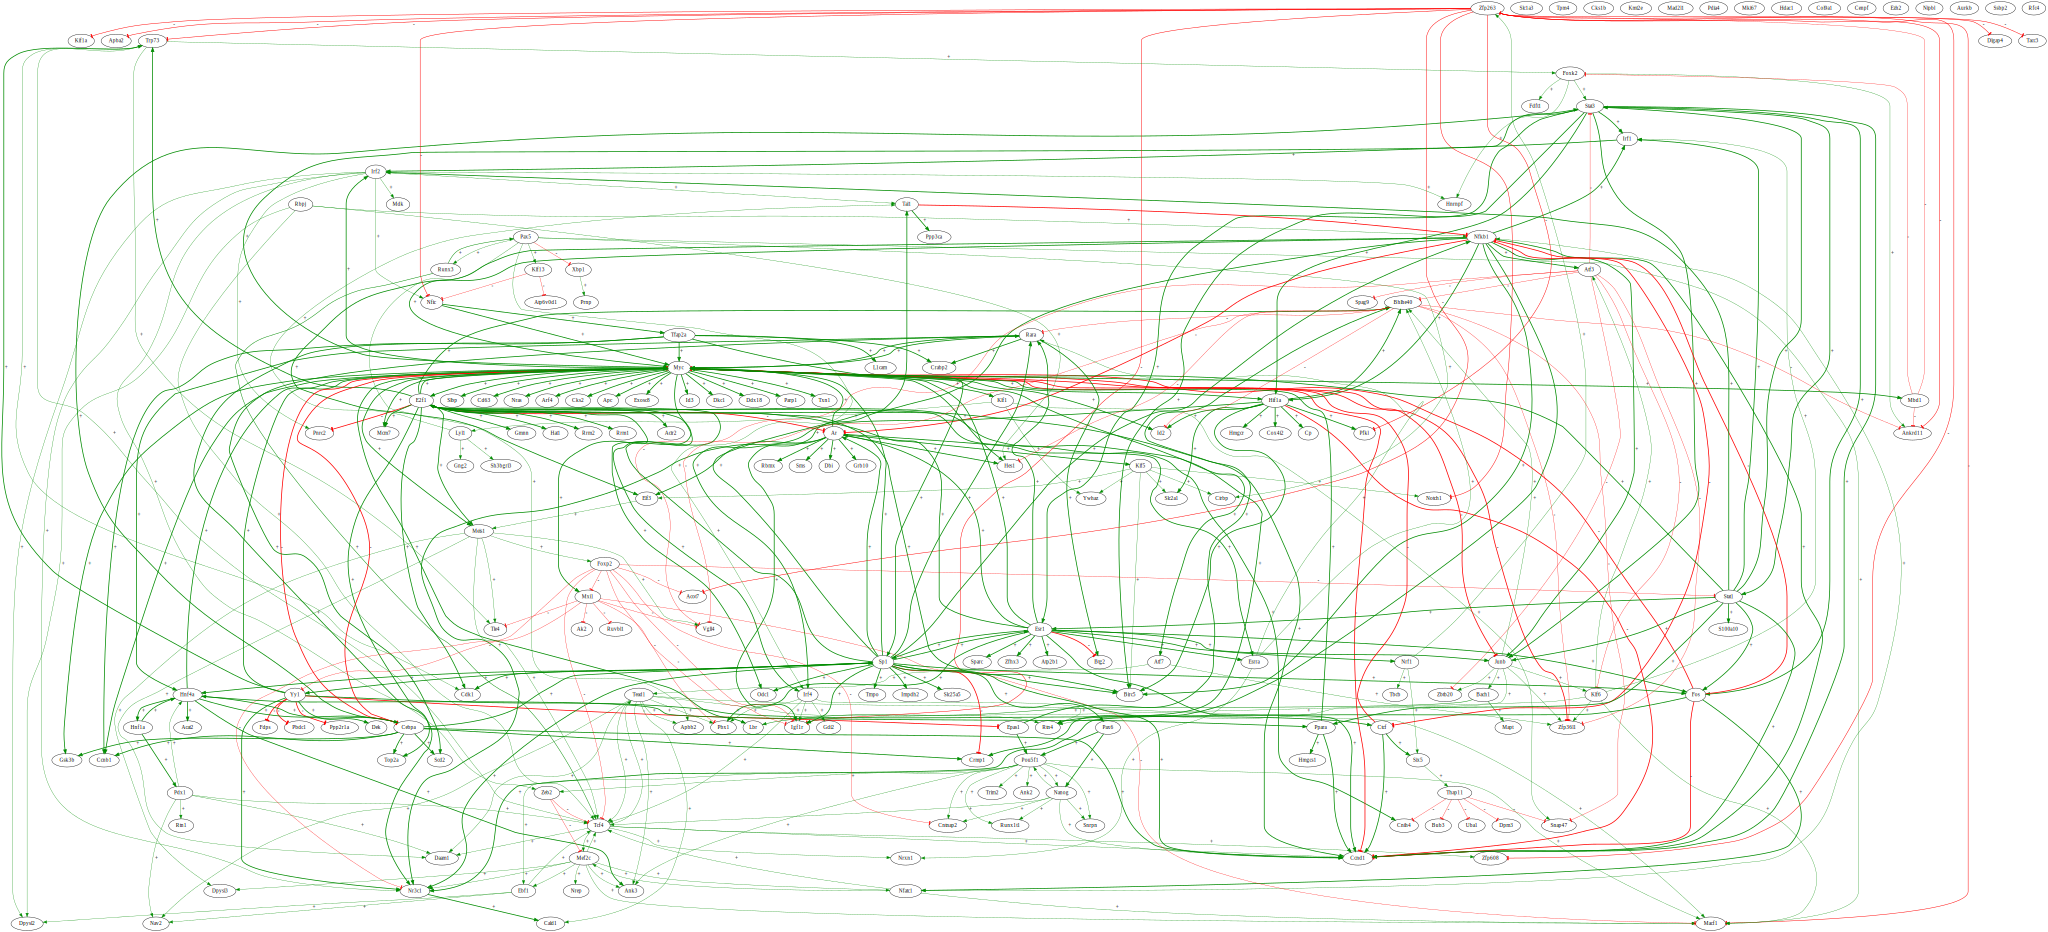

In [70]:
bonesis.InfluenceGraph(_replica_grn)

In [71]:
EXPORT = True

if EXPORT:
    nx.nx_pydot.write_dot(extract_largest_scc(bonesis.InfluenceGraph(_replica_grn)), "sum_grn_scc_v1.dot")
    import json
    with open("sum_grn_optimized_v1.json", "w") as f:
        json.dump(nx.node_link_data(_replica_grn), f)
    
    with open("sum_pkn_bonesis_obj_optimized_v1.json", "w") as f:
        json.dump(nx.node_link_data(bonesis.InfluenceGraph(_replica_grn)), f)
    print("Exported")
else:
    print("Not exported")

Exported
